## Parameter estimation of Lorenz Equation using DiffEqBayes.jl

In [1]:
using DiffEqBayes
using Distributions
using DifferentialEquations
using Plots

INFO: Recompiling stale cache file /home/vaibhav/.julia/lib/v0.6/Gadfly.ji for module Gadfly.
  likely near /home/vaibhav/.julia/v0.6/KernelDensity/src/univariate.jl:80


[Turing]: AD chunk size is set as 40


INFO: Recompiling stale cache file /home/vaibhav/.julia/lib/v0.6/Plots.ji for module Plots.
ArgumentError: Module Hiccup not found in current path.
Run `Pkg.add("Hiccup")` to install the Hiccup package.


In [2]:
gr(fmt=:png)

Plots.GRBackend()

#### Initializing the problem

In [3]:
g1 = @ode_def_bare LorenzExample begin
  dx = σ*(y-x)
  dy = x*(ρ-z) - y
  dz = x*y - β*z
end σ ρ β 

(::LorenzExample) (generic function with 2 methods)

In [5]:
r0 = [1.0; 0.0; 0.0]                
tspan = (0.0, 30.0)
p = [10.0,28.0,2.66]

3-element Array{Float64,1}:
 10.0 
 28.0 
  2.66

In [6]:
prob = ODEProblem(g1,r0,tspan,p)
@time sol = solve(prob,Tsit5())

  4.716945 seconds (3.08 M allocations: 177.607 MiB, 2.03% gc time)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 357-element Array{Float64,1}:
  0.0        
  3.56786e-5 
  0.000392465
  0.00326234 
  0.00905769 
  0.0169556  
  0.0276884  
  0.0418539  
  0.0602369  
  0.0836807  
  0.113359   
  0.148617   
  0.187037   
  ⋮          
 29.2024     
 29.2868     
 29.3682     
 29.4377     
 29.5106     
 29.5789     
 29.659      
 29.7275     
 29.8105     
 29.907      
 29.9937     
 30.0        
u: 357-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]                    
 [0.999643, 0.000998805, 1.78143e-8]
 [0.996105, 0.0109654, 2.14696e-6]  
 [0.96936, 0.0897687, 0.000143797]  
 [0.924207, 0.242279, 0.0010461]    
 [0.880049, 0.438715, 0.00342406]   
 [0.848333, 0.691528, 0.0084873]    
 [0.8495, 1.01449, 0.0182119]       
 [0.913889, 1.44248, 0.0366944]     
 [1.08882, 2.05219, 0.074029]       
 [1.46076, 3.02043, 0.160047]       
 [2.1626, 4.63308, 0.37716]         
 [3.36836, 7.26747, 0.93653]        
 ⋮   

#### Generating data for bayesian estimation of parameters from the obtained solutions using the `Tsit5` algorithm by adding random noise to it.

In [7]:
t = collect(linspace(1,30,30))
sig = 0.49
data = convert(Array, VectorOfArray([(sol(t[i]) + sig*randn(3)) for i in 1:length(t)]))

3×30 Array{Float64,2}:
  -9.68411  -8.70577  -8.81092   -9.08371  …  -10.9209   -3.88407  -13.24  
 -10.0895   -8.23165  -7.57004  -10.8919       -5.78888  -3.87873  -18.1814
  28.3445   24.6687   28.3505    26.7413       33.7898   17.255     26.0194

#### Plots of the generated data and the actual data.


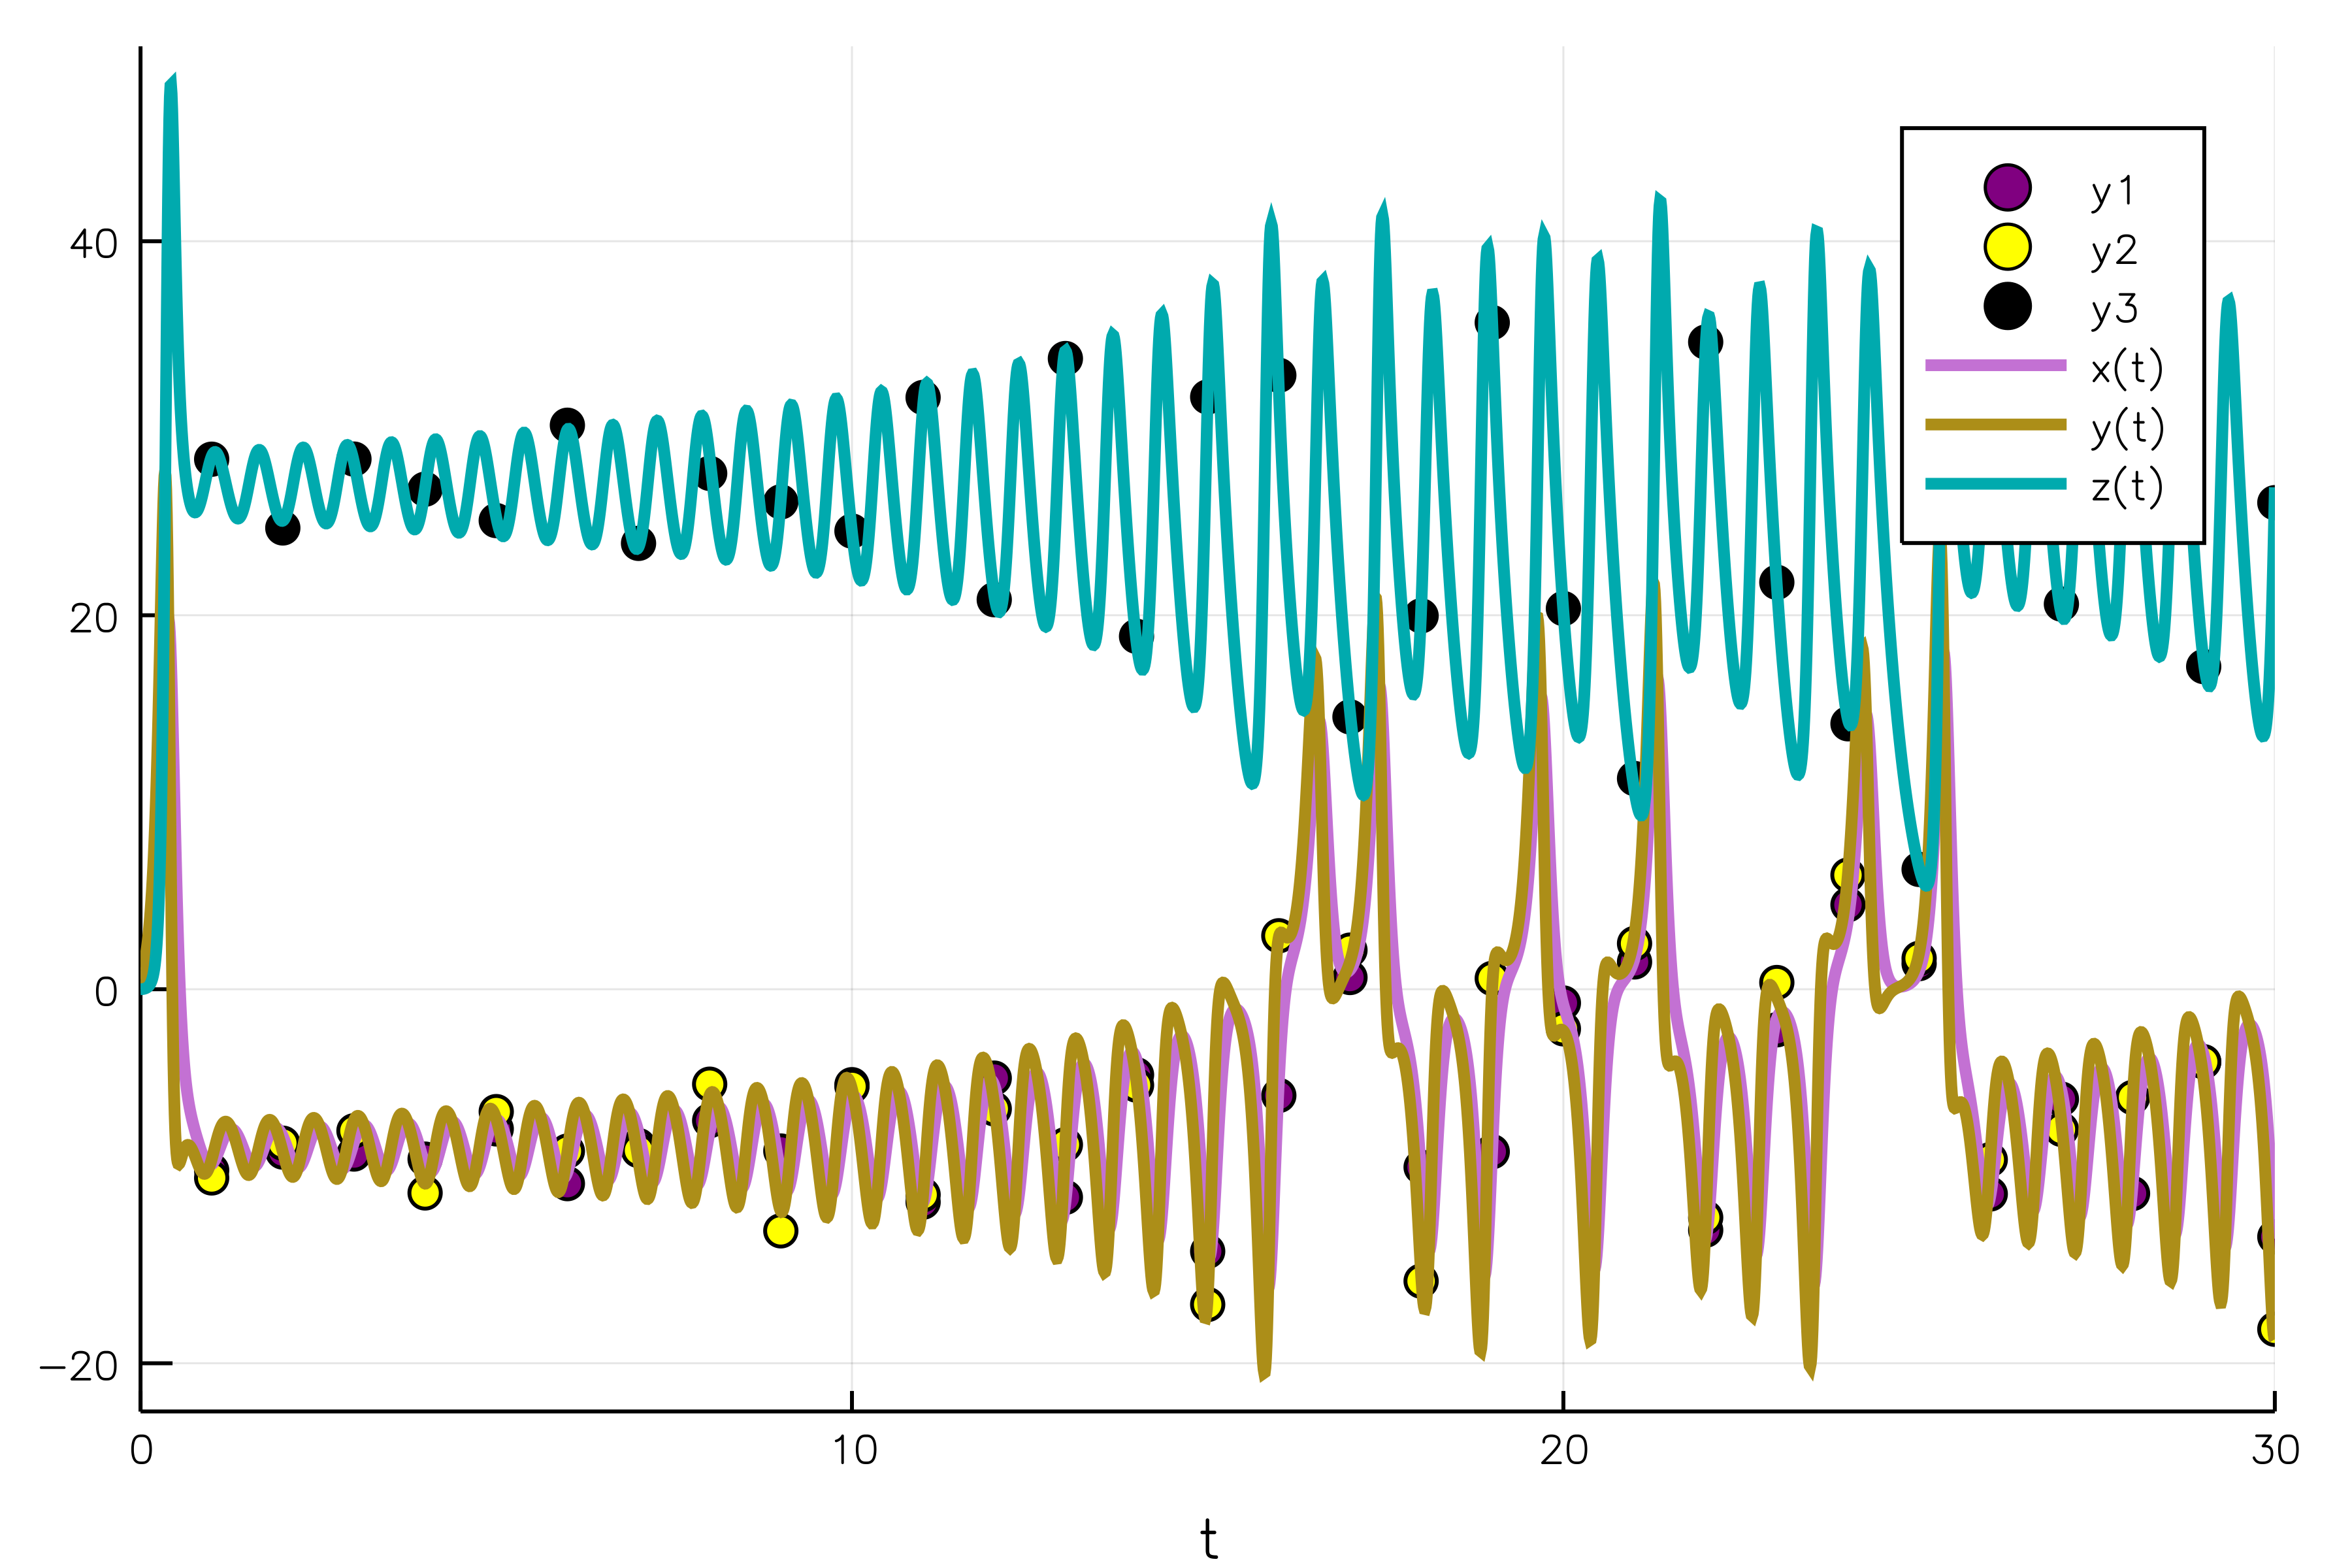

In [8]:
Plots.scatter(t, data[1,:],markersize=4,color=:purple)
Plots.scatter!(t, data[2,:],markersize=4,color=:yellow)
Plots.scatter!(t, data[3,:],markersize=4,color=:black)
plot!(sol)

#### Uncertainity Quantification plot is used to decide the tolerance for the differential equation.


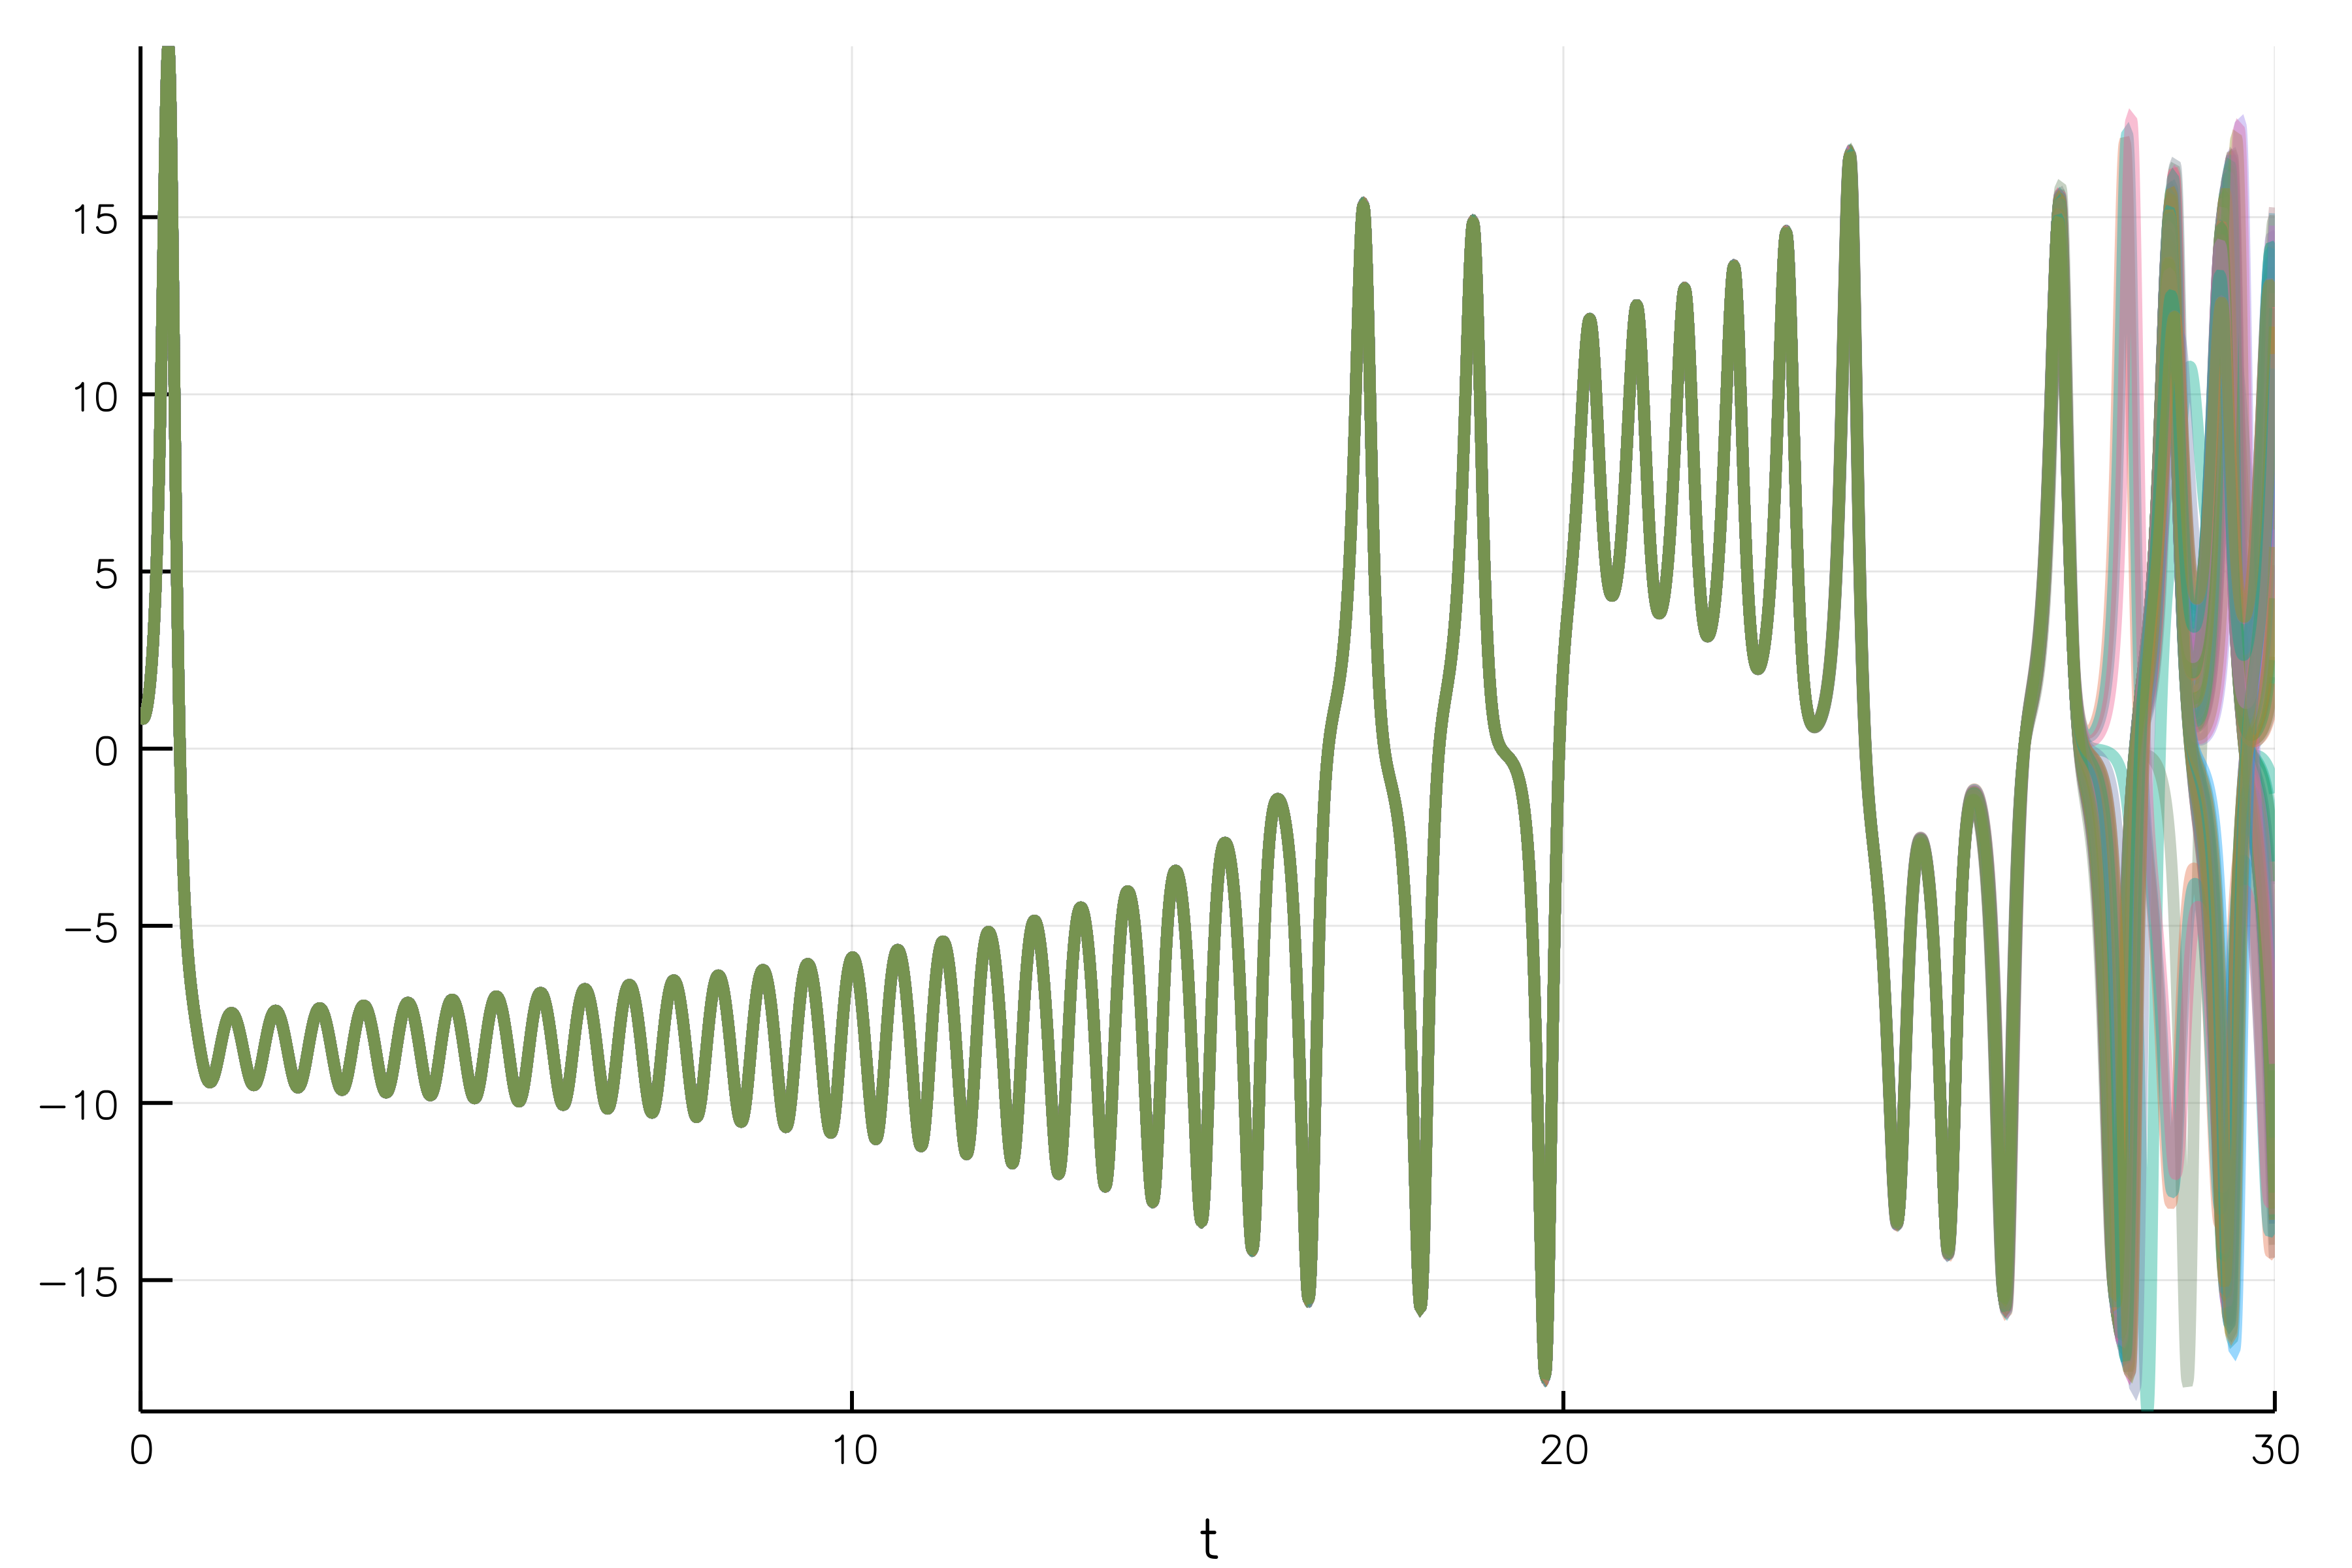

In [9]:
cb = AdaptiveProbIntsUncertainty(5)
monte_prob = MonteCarloProblem(prob)
sim = solve(monte_prob,Tsit5(),num_monte=100,callback=cb,reltol=1e-5,abstol=1e-5)
plot(sim,vars=(0,1),linealpha=0.4)


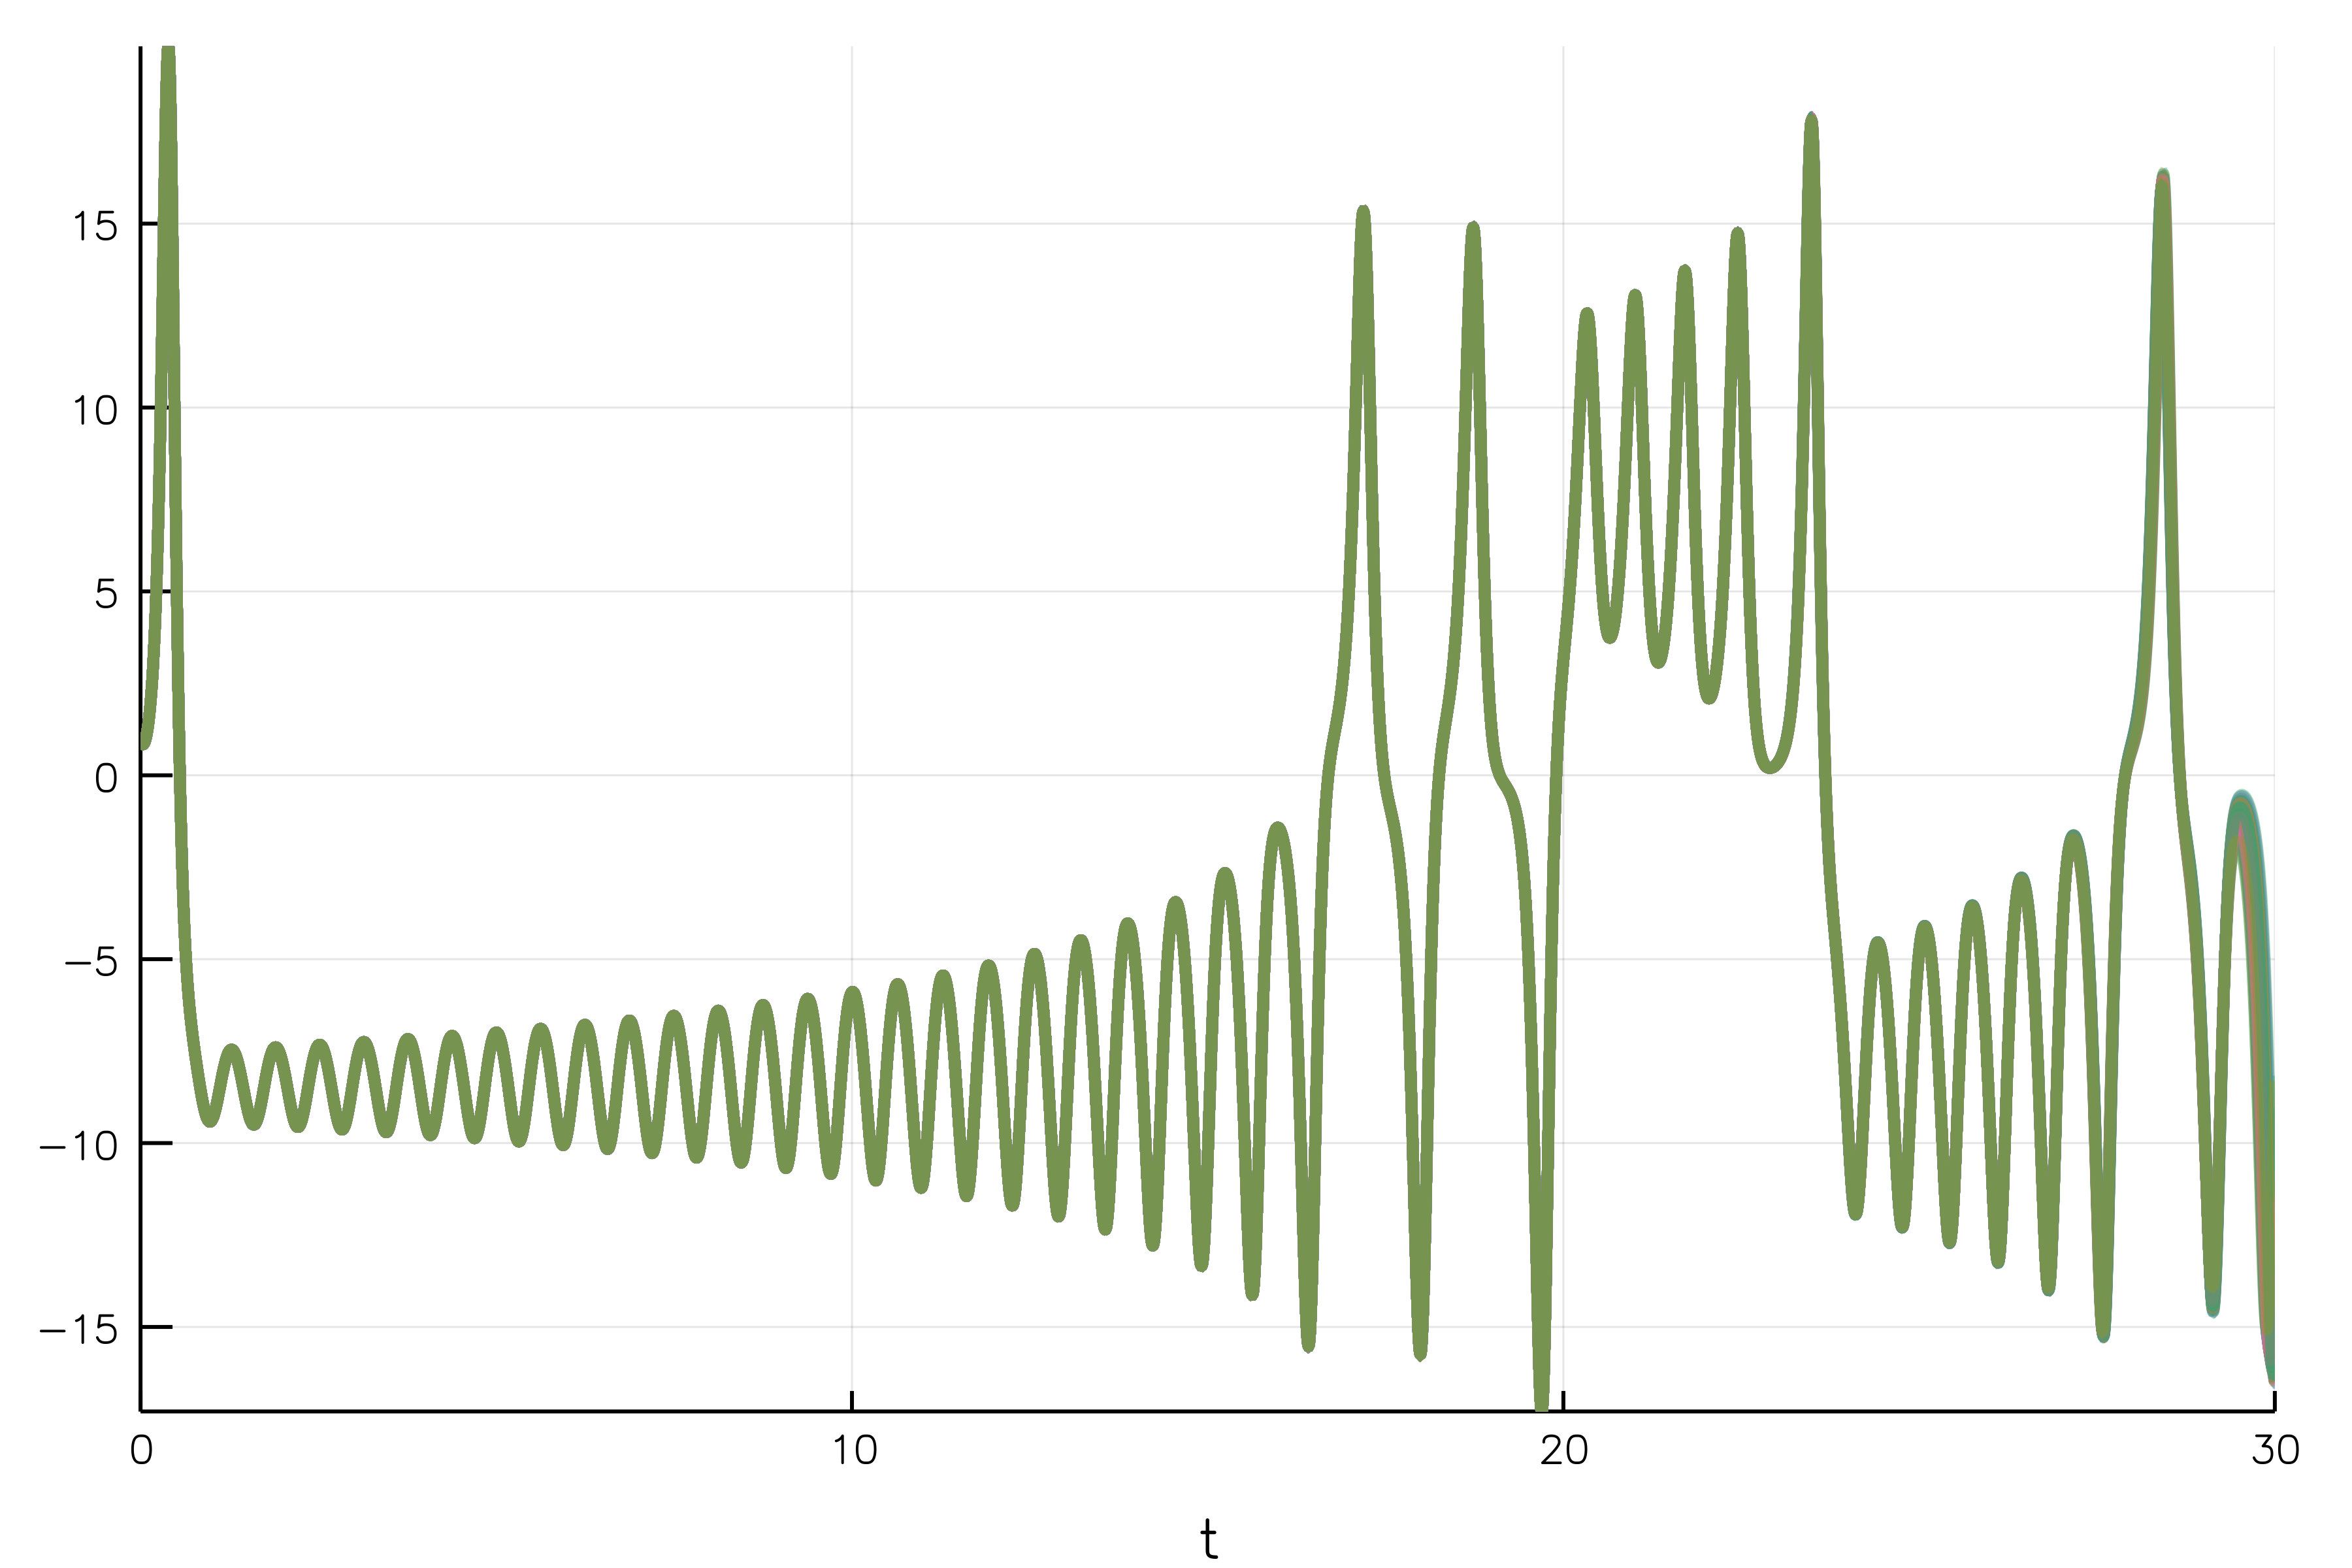

In [11]:
cb = AdaptiveProbIntsUncertainty(5)
monte_prob = MonteCarloProblem(prob)
sim = solve(monte_prob,Tsit5(),num_monte=100,callback=cb,reltol=1e-6,abstol=1e-6)
plot(sim,vars=(0,1),linealpha=0.4)


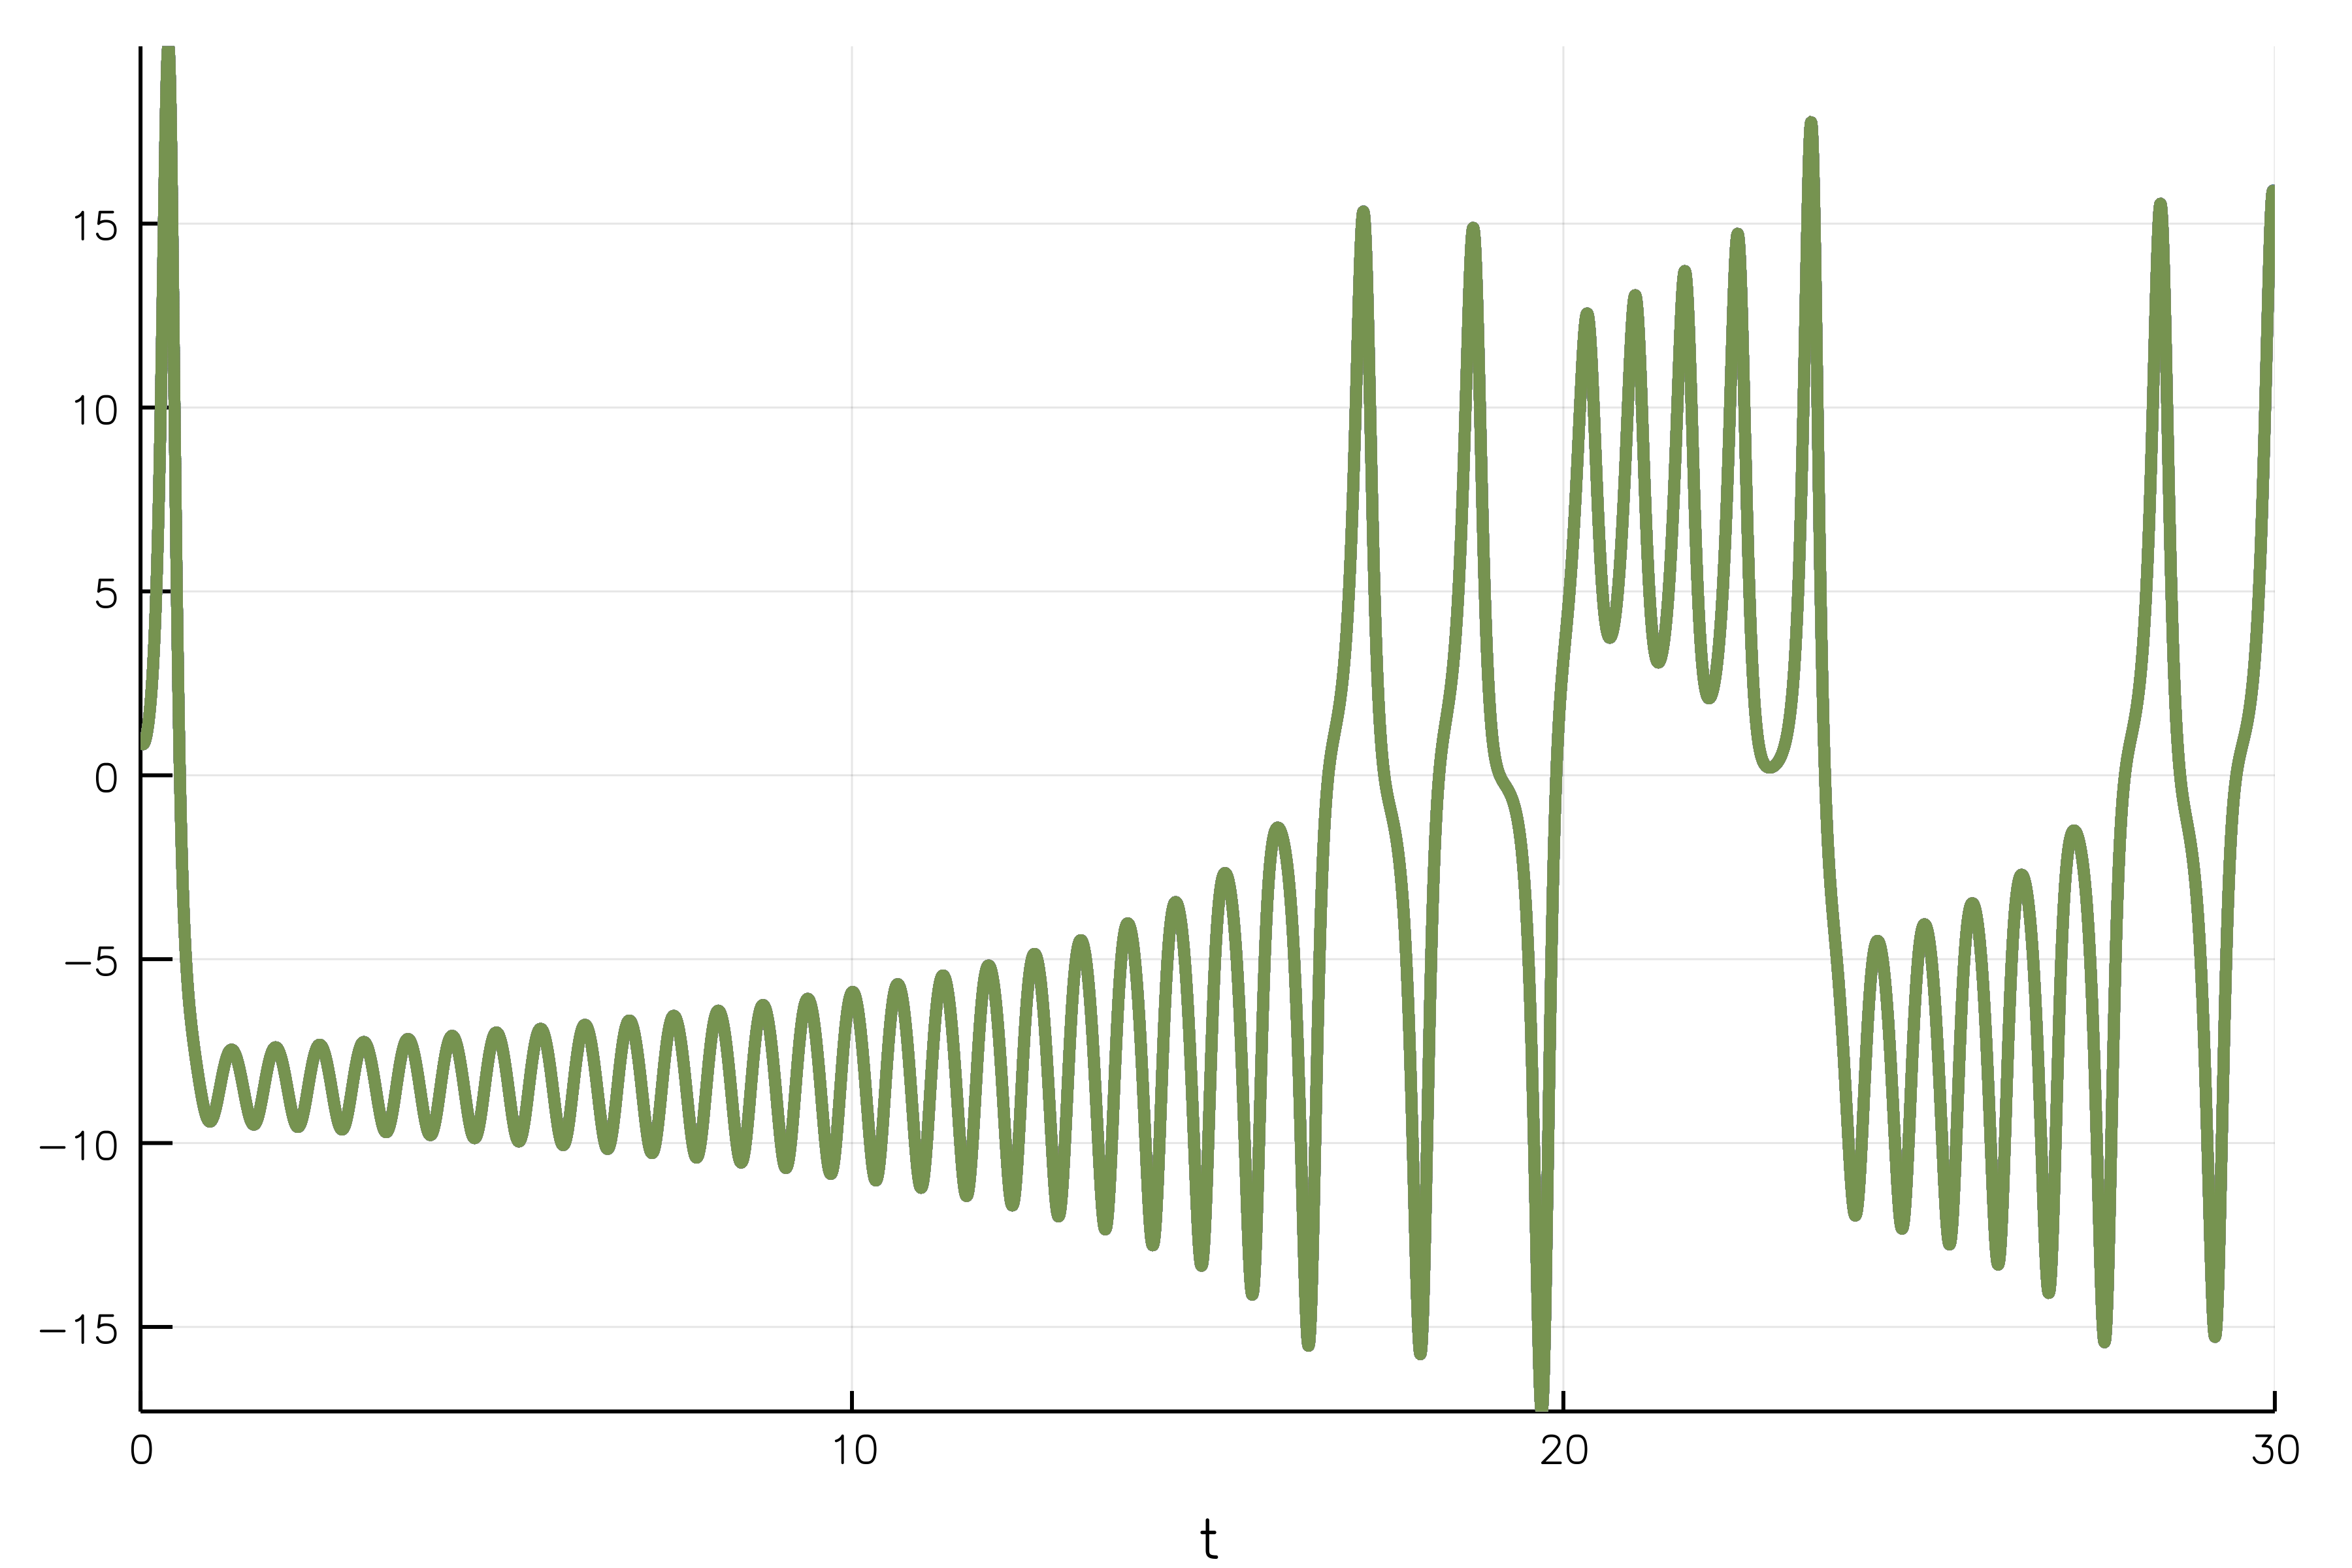

In [9]:
cb = AdaptiveProbIntsUncertainty(5)
monte_prob = MonteCarloProblem(prob)
sim = solve(monte_prob,Tsit5(),num_monte=100,callback=cb,reltol=1e-8,abstol=1e-8)
plot(sim,vars=(0,1),linealpha=0.4)

In [9]:
priors = [Truncated(Normal(10,2),1,15),Truncated(Normal(30,5),1,45),Truncated(Normal(2.5,0.5),1,4)]

3-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous},1}:
 Truncated(Distributions.Normal{Float64}(μ=10.0, σ=2.0), range=(1.0, 15.0))
 Truncated(Distributions.Normal{Float64}(μ=30.0, σ=5.0), range=(1.0, 45.0))
 Truncated(Distributions.Normal{Float64}(μ=2.5, σ=0.5), range=(1.0, 4.0))  

## Parameter Estimation using Stan.jl backend.

Lorenz equation is a chaotic system hence requires very low tolerance to be estimated in a reasonable way, we use 1e-8 obtained from the uncertainity plots. Use of Truncated priors is necessary to prevent Stan from stepping into negative and other improbable areas.

In [10]:
@time bayesian_result = stan_inference(prob,t,data,priors;num_samples=100,num_warmup=500,reltol=1e-8,abstol=1e-8,vars =(StanODEData(),InverseGamma(3,2)))


File /home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.stan will be updated.



--- Translating Stan model to C++ code ---
bin/stanc  /home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.stan --o=/home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.hpp
Model name=parameter_estimation_model_model
Input file=/home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.stan
Output file=/home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model.hpp

--- Linking C++ model ---
g++ -I src -I stan/src -isystem stan/lib/stan_math/ -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.62.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe   -lpthread  -O3 -o /home/vaibhav/DiffEqBayes.jl/notebook/tmp/parameter_estimation_model src/cmdstan/main.cpp -i

DiffEqBayes.StanModel{Int64,Mamba.Chains}(0, Object of type "Mamba.Chains"

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

[-100003.0 0.68405 … 29.4784 1.06274; -100003.0 0.963131 … 29.4784 1.06274; … ; -99799.3 0.558286 … 29.4821 1.06281; -99800.5 0.999053 … 29.4821 1.0628]

[-281.267 0.999538 … 33.5824 0.878635; -277.126 0.999247 … 33.6798 0.887147; … ; -274.448 0.232303 … 33.8254 0.888897; -274.19 0.464807 … 33.8001 0.8878]

[-2867.07 0.955846 … 27.0036 0.542668; -2866.79 0.997342 … 27.0035 0.542668; … ; -2867.15 0.960805 … 27.0036 0.542661; -2867.77 0.880972 … 27.0036 0.54266]

[-213.044 0.804451 … 24.5947 1.98568; -212.998 0.98218 … 24.714 1.96381; … ; -218.685 0.973598 … 24.4033 2.01614; -214.177 0.977675 … 24.4374 2.01644])

In [11]:
Mamba.describe(bayesian_result.chain_results)

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

Empirical Posterior Estimates:
                     Mean               SD            Naive SE           MCSE           ESS    
         lp__   -2.58157383×10⁴    4.28403707×10⁴ 2142.0185329162    2.47029572×10⁴   3.0075202
accept_stat__  8.606830953×10⁻¹  2.076105942×10⁻¹    0.0103805297 3.8722752318×10⁻²  28.7452828
   stepsize__ 2.9482791442×10⁻² 2.9764710587×10⁻²    0.0014882355 1.7163169398×10⁻²   3.0075188
  treedepth__     7.5150000×10⁰    2.55265845×10⁰    0.1276329225    1.42172724×10⁰   3.2236869
 n_leapfrog__     5.3232750×10²    4.87547235×10²   24.3773617322    2.79253235×10²   3.0481545
  divergent__    2.7500000×10⁻²  1.637399675×10⁻¹    0.0081869984 1.6007810594×10⁻² 100.0000000
     energy__    2.58193554×10⁴    4.28412009×10⁴ 2142.0600466074    2.47034359×10⁴   3.0075202
     sigma1.1    5.27606608×10⁰     2.3585029×10⁰    0.1179251451    1.29974305×10⁰   3.2927429
     sigma1.2    4.841

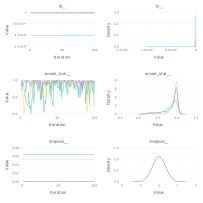

Press ENTER to draw next plot
STDIN> 


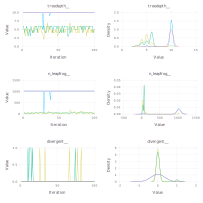

Press ENTER to draw next plot
STDIN> 


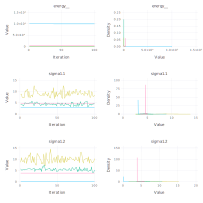

Press ENTER to draw next plot
STDIN> 


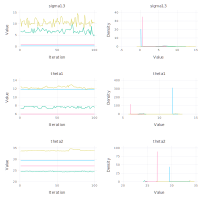

Press ENTER to draw next plot
STDIN> 


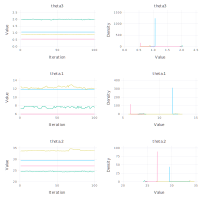

Press ENTER to draw next plot
STDIN> 


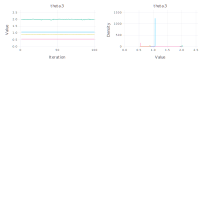

In [12]:
plot_chain(bayesian_result)

## Conclusion

Due to the chaotic nature of Lorenz Equation, it is a very hard problem to estimate as it has the property of exponentially increasing errors. Its uncertainity plot points to its chaotic behaviour and goes awry for different values of tolerance, we use 1e-8 as the tolerance as it makes its uncertainity small enough to be trusted in `(0,30)` time span.

The behaviour is estimation using Stan.jl backend is as expected and it gives more accurate results as we decrease the tolerance, for 1e-8 we obtain quite accurate results as compared to higher tolerance values but lowering the tolerance leads to longer sampling time, incase of 1e-8 it takes 8.4 hours. We also pass 500 warmup samples for proper convergence, as the plots provide evidence of non-convergence without it which observed over multiple runs. 